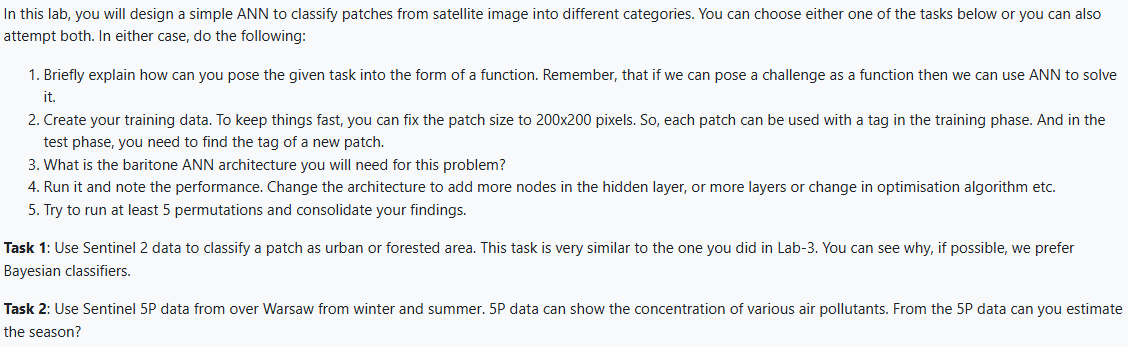

In [1]:
import glob
import rasterio
import numpy as np
from rasterio.windows import from_bounds
from pyproj import Transformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

For this lab I am switching from Mielec to Krakow as Mielec has to much "green" areas overall for the model training.

In [2]:
# Paths to the 10m bands for both urban and rural areas
folder_u = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2C_MSIL2A_20251119T094321_N0511_R036_T34UDA_20251119T113511.SAFE\\GRANULE\\L2A_T34UDA_A006298_20251119T094316\\IMG_DATA\\R10m"
folder_a = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2A_MSIL2A_20251027T141101_N0511_R110_T21MWV_20251027T171317.SAFE\\GRANULE\\L2A_T21MWV_A054047_20251027T141102\\IMG_DATA\\R10m"
# Paths to the r g and b bands 
band_paths_u = {b: glob.glob(f"{folder_u}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
band_paths_a = {b: glob.glob(f"{folder_a}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
# combine band paths into a single list
band_paths = [band_paths_u, band_paths_a]

In [3]:
def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

PATCH_SIZE = 200    # 100x100 pixels
PIXEL_SIZE = 10     # Sentinel-2 10m resolution

# Pick any band from each scene
with rasterio.open(band_paths_u["B04"]) as src_u:
    crs_u = src_u.crs
with rasterio.open(band_paths_a["B04"]) as src_a:
    crs_a = src_a.crs  # should be EPSG:32621

# Build per-scene transformers
transformer_u = Transformer.from_crs("EPSG:4326", crs_u, always_xy=True)
transformer_a = Transformer.from_crs("EPSG:4326", crs_a, always_xy=True)

def extract_patch(lat, lon):
    # choose which scene based on lon/flag
    if lon < -30:  # Amazon side
        transformer = transformer_a
        bands = band_paths_a
    else:          # Kraków side
        transformer = transformer_u
        bands = band_paths_u

    x, y = transformer.transform(lon, lat)
    dx = PIXEL_SIZE * PATCH_SIZE // 2
    dy = PIXEL_SIZE * PATCH_SIZE // 2

    xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy
    scale = 1.0 / 10000.0
    b4 = read_crop(bands["B04"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale
    b3 = read_crop(bands["B03"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale
    b2 = read_crop(bands["B02"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale
    patch = np.dstack((b4, b3, b2))
    return patch if patch.shape == (PATCH_SIZE, PATCH_SIZE, 3) else None

For rainforest area are picked at random. For city they are coordinates of main urban parts of the city in order to exclude non urban parts like parks, lakes etc.

In [4]:
def pick_points(lon, lat, n_points, spread):
    lons = lon + spread * (np.random.rand(n_points) - 0.5) * 2  # random from -1 to 1 scaled by spread
    lats = lat + spread * (np.random.rand(n_points) - 0.5) * 2
    return list(zip(lats, lons))

lon_a, lat_a = -56.714447, -0.312698     # Amazon Rainforest tile center coordinates

urban_centers = [
    (50.06143, 19.93722),   # Rynek Główny
    (50.0645,  19.9480),    # Galeria Krakowska / Dworzec
    (50.0545,  19.9360),    # Kazimierz
    (50.0475,  19.9450),    # Podgórze
    (50.0730,  19.9400),    # Old Town north
    (50.0860,  19.9200),    # Krowodrza
    (50.0800,  19.9600),    # Grzegórzki
    (50.0700,  19.9800),    # Dąbie
    (50.0805,  19.8900),    # Bronowice
    (50.0950,  19.9300),    # Prądnik Biały
    (50.0240,  19.9500),    # Kurdwanów
    (50.0370,  19.9400),    # Łagiewniki
    (50.0700,  20.0000),    # Mogilska / Czyżyny
    (50.0780,  20.0200),    # Nowa Huta – central
    (50.0900,  20.0300),    # Nowa Huta – east
    (50.0580,  20.0100),    # Płaszów
    (50.0500,  19.9800),    # Zabłocie / industrial
    (50.0300,  19.9700),    # Ruczaj / Kampus UJ
]

forest_centers = pick_points(lon_a, lat_a, n_points=18, spread=0.3)

len(urban_centers), len(forest_centers)

(18, 18)

In [5]:
import xml.etree.ElementTree as ET

# Path to metadata file
meta_path = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2A_MSIL2A_20251027T141101_N0511_R110_T21MWV_20251027T171317.SAFE\\MTD_MSIL2A.xml"

tree = ET.parse(meta_path)
root = tree.getroot()

# Extract geographic bounds
geo_info = root.find(".//Product_Footprint/Product_Footprint/Global_Footprint/EXT_POS_LIST")
if geo_info is not None:
    coords = list(map(float, geo_info.text.split()))
    # Coords come as lat1 lon1 lat2 lon2 lat3 lon3 lat4 lon4
    lats = coords[0::2]
    lons = coords[1::2]
    
    print(f"Corner coordinates:")
    for i, (lat, lon) in enumerate(zip(lats, lons)):
        print(f"  Corner {i+1}: ({lat:.6f}, {lon:.6f})")
    
    center_lat = sum(lats) / len(lats)
    center_lon = sum(lons) / len(lons)
    print(f"\nCenter: ({center_lat:.6f}, {center_lon:.6f})")

Corner coordinates:
  Corner 1: (-0.080716, -57.000180)
  Corner 2: (-0.040812, -56.991385)
  Corner 3: (0.000000, -56.982382)
  Corner 4: (0.000000, -56.013484)
  Corner 5: (-0.993246, -56.013337)
  Corner 6: (-0.993394, -57.000180)
  Corner 7: (-0.080716, -57.000180)

Center: (-0.312698, -56.714447)


Labeling data and spliting it to training and testing datasets

In [6]:
X = []
y = []

# urban = 1
for lat, lon in urban_centers:
    patch = extract_patch(lat, lon)
    if patch is not None:
        X.append(patch)
        y.append(1)

# forest = 0
for lat, lon in forest_centers:
    patch = extract_patch(lat, lon)
    if patch is not None:
        X.append(patch)
        y.append(0)

X = np.stack(X)
y = np.array(y).astype("float32")

print("Dataset shape:", X.shape)
print("Labels count:", np.bincount(y.astype(int)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

Dataset shape: (35, 200, 200, 3)
Labels count: [17 18]


Setup for model creation

In [7]:

input_shape=(200, 200, 3)

def make_model(first_layer_units, second_layer_units, activation_func):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten()
    ])
    
    model.add(layers.Dense(first_layer_units, activation=activation_func))
    
    if second_layer_units != 0:
        model.add(layers.Dense(second_layer_units, activation=activation_func))

    model.add(layers.Dense(1, activation="sigmoid"))
    
    return model


def compile_and_train(model, X_train, y_train, epochs=20, verbose=1):
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_split=0.2,# adding validation dataset (20% of test dataset)
        batch_size=32,
        verbose=verbose
    )
    
    return history


def plot_training_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    # Plot accuracy and loss side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

    # Accuracy plot
    axs[0].plot(epochs, acc, "o-", label="Training accuracy")
    axs[0].plot(epochs, val_acc, "o-", label="Validation accuracy")
    axs[0].set_title("Training and Validation Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Loss plot
    axs[1].plot(epochs, loss, "o-", label="Training loss")
    axs[1].plot(epochs, val_loss, "o-", label="Validation loss")
    axs[1].set_title("Training and Validation Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show() 

### Model 1 - As simple as possbile


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step - accuracy: 0.4545 - loss: 0.7148 - val_accuracy: 0.3333 - val_loss: 4.6279
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5455 - loss: 3.1956 - val_accuracy: 0.6667 - val_loss: 5.8150
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4545 - loss: 9.3770 - val_accuracy: 0.6667 - val_loss: 3.7570
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4545 - loss: 6.0384 - val_accuracy: 0.3333 - val_loss: 3.8631
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5455 - loss: 2.5250 - val_accuracy: 0.3333 - val_loss: 6.1991
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5455 - loss: 4.0732 - val_accuracy: 0.3333 - val_loss: 2.5148
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5455 - loss: 1.4869 - val_accuracy: 0.6667 - val_loss: 2.3312
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4545 - loss: 3.6826 - val_accuracy: 0.6667 - val_loss

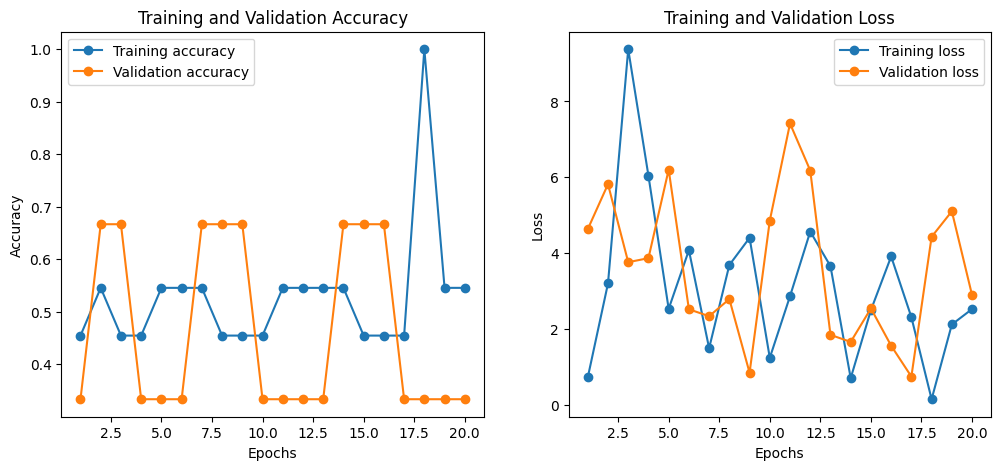

In [8]:
tf.keras.backend.clear_session()
model_1 = make_model(64, 0, "relu")
history_1 = compile_and_train(model_1, X_train, y_train, epochs=20)
plot_training_history(history_1)

Results are more of a coin flip than a real coin flip

### Model 2 - Still simple (2 equal layers)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step - accuracy: 0.5455 - loss: 0.6973 - val_accuracy: 0.3333 - val_loss: 1.8834
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5455 - loss: 1.1699 - val_accuracy: 0.6667 - val_loss: 4.7025
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4545 - loss: 7.5780 - val_accuracy: 0.6667 - val_loss: 1.1891
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4545 - loss: 1.8819 - val_accuracy: 0.3333 - val_loss: 6.7739
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5455 - loss: 4.5290 - val_accuracy: 0.3333 - val_loss: 8.5237
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5455 - loss: 5.6713 - val_accuracy: 0.3333 - val_loss: 6.4026
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5455 - loss: 4.2169 - val_accuracy: 0.3333 - val_loss: 1.4053
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5455 - loss: 0.7728 - val_accuracy: 0.6667 - val_loss:

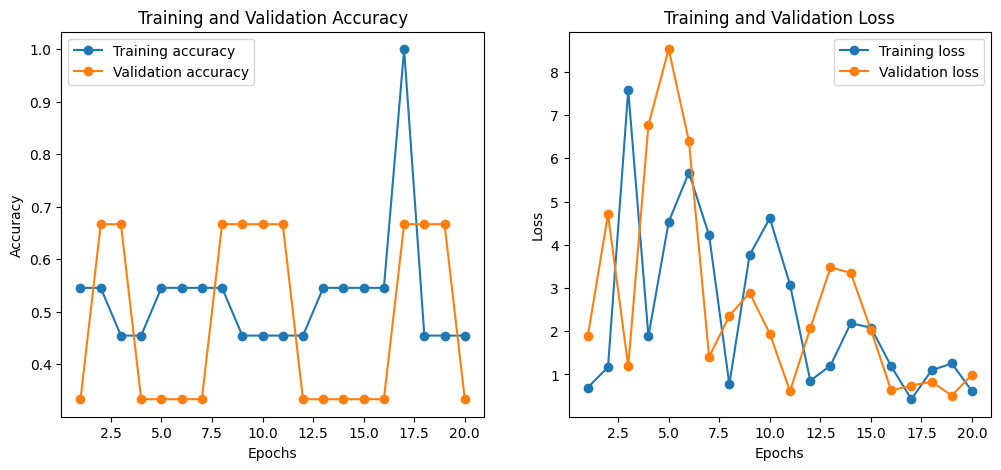

In [9]:
tf.keras.backend.clear_session()
model_2 = make_model(64, 64, "relu")
history_2 = compile_and_train(model_2, X_train, y_train, epochs=20)
plot_training_history(history_2)

Still not the best results but less random than previous model. (I guess????)

More points (more data). data_prep notebook prepares data for the models to use. Json files are used to help to store points, bounding boxes positions, etc in a file.

In [10]:
# gotta fix some functions first
PATCH_SIZE = 200    # 100x100 pixels
PIXEL_SIZE = 10     # Sentinel-2 10m resolution

# Pick any band from each scene
with rasterio.open(band_paths_u["B04"]) as src_u:
    crs_u = src_u.crs
with rasterio.open(band_paths_a["B04"]) as src_a:
    crs_a = src_a.crs  # should be EPSG:32621

# Build per-scene transformers
transformer_u = Transformer.from_crs("EPSG:4326", crs_u, always_xy=True)
transformer_a = Transformer.from_crs("EPSG:4326", crs_a, always_xy=True)


def extract_patch(lat, lon):
    # choose which scene based on lon/flag
    if lon < -30:  # Amazon side
        transformer = transformer_a
        bands = band_paths_a
    else:          # Kraków side
        transformer = transformer_u
        bands = band_paths_u

    x, y = transformer.transform(lon, lat)
    dx = PIXEL_SIZE * PATCH_SIZE // 2
    dy = PIXEL_SIZE * PATCH_SIZE // 2

    xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy
    scale = 1.0 / 10000.0
    b4 = read_crop(bands["B04"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale
    b3 = read_crop(bands["B03"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale
    b2 = read_crop(bands["B02"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale
    patch = np.dstack((b4, b3, b2))
    return patch if patch.shape == (PATCH_SIZE, PATCH_SIZE, 3) else None

In [11]:
import json

# Load urban metadata
with open(r"C:\\Users\\kacpe\\Desktop\\Studia\\ML\\cities\\cities_bound_box_center.json") as f:
    urban_meta = json.load(f)

# Load bands for all cities
urban_bands = {}
for city, meta in urban_meta.items():
    tif_path = meta['file']
    with rasterio.open(tif_path) as src:
        # Read all bands (typically RGB = B04, B03, B02)
        bands = src.read()  # shape: (n_bands, height, width)
        # Normalize to 0-1 range
        bands = bands.astype(np.float32) / bands.max()
        urban_bands[city] = {
            'data': bands,
            'bbox': meta['bbox'],
            'center': meta['center'],
            'shape': bands.shape
        }

print(f"\nLoaded all {len(urban_bands)} cities")

X = []
y = []

# urban = 1
for lat, lon in urban_centers:
    patch = extract_patch(lat, lon)
    if patch is not None:
        X.append(patch)
        y.append(1)



Loaded all 10 cities


In [12]:
# Load forests metadata
with open(r"C:\\Users\\kacpe\\Desktop\\Studia\\ML\\forests\\forests_bound_box_center.json") as f:
    forests_meta = json.load(f)

print(f"Loaded {len(forests_meta)} cities")
for city in forests_meta.keys():
    print(f"  {city}")

# Load bands for all cities
forests_bands = {}
for city, meta in forests_meta.items():
    tif_path = meta['file']
    with rasterio.open(tif_path) as src:
        # Read all bands (typically RGB = B04, B03, B02)
        bands = src.read()  # shape: (n_bands, height, width)
        # Normalize to 0-1 range
        bands = bands.astype(np.float32) / bands.max()
        forests_bands[city] = {
            'data': bands,
            'bbox': meta['bbox'],
            'center': meta['center'],
            'shape': bands.shape
        }
    print(f"  {city}: {bands.shape}")

print(f"\nLoaded all {len(forests_bands)} forests")

Loaded 10 cities
  amazon
  bornean
  canadian
  congo
  european
  new
  sumatra
  taiga
  tongass
  valdivian
  amazon: (3, 1107, 1114)
  bornean: (3, 1109, 1116)
  canadian: (3, 1114, 626)
  congo: (3, 1109, 1116)
  european: (3, 1123, 762)
  new: (3, 1111, 1113)
  sumatra: (3, 1108, 1115)
  taiga: (3, 1123, 542)
  tongass: (3, 1123, 617)
  valdivian: (3, 1140, 892)

Loaded all 10 forests


In [13]:
# New functions to handle the downloaded tifs

def extract_patch_from_bands(bands_dict, lat, lon, patch_size=200):
    """
    Extract a square patch centered at (lat, lon) from band data.
    bands_dict: dict with 'data' (C, H, W), 'bbox' (west, south, east, north), 'center'
    Returns: patch of shape (patch_size, patch_size, 3) or None if out of bounds
    """
    bbox = bands_dict['bbox']
    data = bands_dict['data']  # (C, H, W)

    H, W = data.shape[1], data.shape[2]

    # Normalize lat/lon to [0, 1]
    x_norm = (lon - bbox['west']) / (bbox['east'] - bbox['west'])
    y_norm = (bbox['north'] - lat) / (bbox['north'] - bbox['south'])

    # Convert to pixel coordinates
    x_pixel = int(x_norm * W)
    y_pixel = int(y_norm * H)

    half_size = patch_size // 2
    y_start = max(0, y_pixel - half_size)
    y_end = min(H, y_pixel + half_size)
    x_start = max(0, x_pixel - half_size)
    x_end = min(W, x_pixel + half_size)

    # Check if patch is valid (not clipped too much)
    if (y_end - y_start < patch_size * 0.9) or (x_end - x_start < patch_size * 0.9):
        return None  # Too close to edge

    # Extract RGB bands (first 3)
    patch = data[:3, y_start:y_end, x_start:x_end]  # (3, H, W)
    patch = np.transpose(patch, (1, 2, 0))  # -> (H, W, 3)

    return patch if patch.shape == (patch_size, patch_size, 3) else None


# Generate random sample points within each bbox (kept for forests)
def generate_points_in_bbox(bbox, n_points, margin=0.05):
    """Generate random points within a bbox, with margin from edges."""
    west, south, east, north = bbox['west'], bbox['south'], bbox['east'], bbox['north']

    # Add margin
    w_margin = (east - west) * margin
    s_margin = (north - south) * margin

    lons = np.random.uniform(west + w_margin, east - w_margin, n_points)
    lats = np.random.uniform(south + s_margin, north - s_margin, n_points)

    return list(zip(lats, lons))

print("=== Extracting patches from cities TIFFs  ===\n")

# Load curated urban points
with open(r"C:\\Users\\kacpe\\Desktop\\Studia\\ML\\cities\\cities_points.json") as f:
    urban_points = json.load(f)

X_urban = []
y_urban = []

# Extract patches from each urban city using provided points
for city, bands_dict in urban_bands.items():
    pts = urban_points.get(city, [])
    if not pts:
        print(f"  {city}: 0 patches (no points in urban_points.json)")
        continue

    extracted_count = 0
    for lon, lat in pts:  # JSON stores [lon, lat]
        patch = extract_patch_from_bands(bands_dict, lat, lon, patch_size=200)
        if patch is not None:
            X_urban.append(patch)
            y_urban.append(1)  # urban = 1
            extracted_count += 1

    print(f"  {city}: {extracted_count} patches")

print(f"\nTotal urban patches: {len(X_urban)}")

print("\n=== Extracting patches from forest TIFFs (random points) ===\n")

X_forest = []
y_forest = []

# Extract patches from each forest using random points (no JSON provided)
for forest, bands_dict in forests_bands.items():
    points = generate_points_in_bbox(bands_dict['bbox'], n_points=10)

    extracted_count = 0
    for lat, lon in points:
        patch = extract_patch_from_bands(bands_dict, lat, lon, patch_size=200)
        if patch is not None:
            X_forest.append(patch)
            y_forest.append(0)  # forest = 0
            extracted_count += 1

    print(f"  {forest}: {extracted_count} patches")

print(f"\nTotal forest patches: {len(X_forest)}")

# Combine datasets
if X_urban and X_forest:
    X = np.concatenate([np.stack(X_urban), np.stack(X_forest)], axis=0)
    y = np.array(y_urban + y_forest, dtype=np.float32)

    print(f"\n=== Final Dataset ===")
    print(f"Total patches: {X.shape[0]}")
    print(f"Shape: {X.shape}")
    print(f"Labels: {np.bincount(y.astype(int))}")
else:
    print("ERROR: No patches extracted!")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)


=== Extracting patches from cities TIFFs  ===

  cairo: 9 patches
  delhi: 10 patches
  london: 7 patches
  los: 10 patches
  mexico: 10 patches
  new: 7 patches
  paris: 10 patches
  sao: 10 patches
  shanghai: 10 patches
  tokyo: 1 patches

Total urban patches: 84

=== Extracting patches from forest TIFFs (random points) ===

  amazon: 8 patches
  bornean: 7 patches
  canadian: 6 patches
  congo: 8 patches
  european: 7 patches
  new: 6 patches
  sumatra: 8 patches
  taiga: 5 patches
  tongass: 7 patches
  valdivian: 9 patches

Total forest patches: 71

=== Final Dataset ===
Total patches: 155
Shape: (155, 200, 200, 3)
Labels: [71 84]


### Model 1 but with plenty of data

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5152 - loss: 2.7827 - val_accuracy: 0.4800 - val_loss: 2.8002
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5859 - loss: 1.8382 - val_accuracy: 0.4800 - val_loss: 1.1412
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4747 - loss: 2.3268 - val_accuracy: 0.4000 - val_loss: 0.8166
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7172 - loss: 1.5417 - val_accuracy: 0.8400 - val_loss: 0.8414
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8889 - loss: 0.3947 - val_accuracy: 0.5600 - val_loss: 0.6848
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8081 - loss: 0.4074 - val_accuracy: 0.8400 - val_loss: 1.2206
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9091 - loss: 0.4809 - val_accuracy: 0.6000 - val_loss: 0.6660
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5455 - loss: 0.8767 - val_accuracy: 0.7200 - val_loss: 0.4823

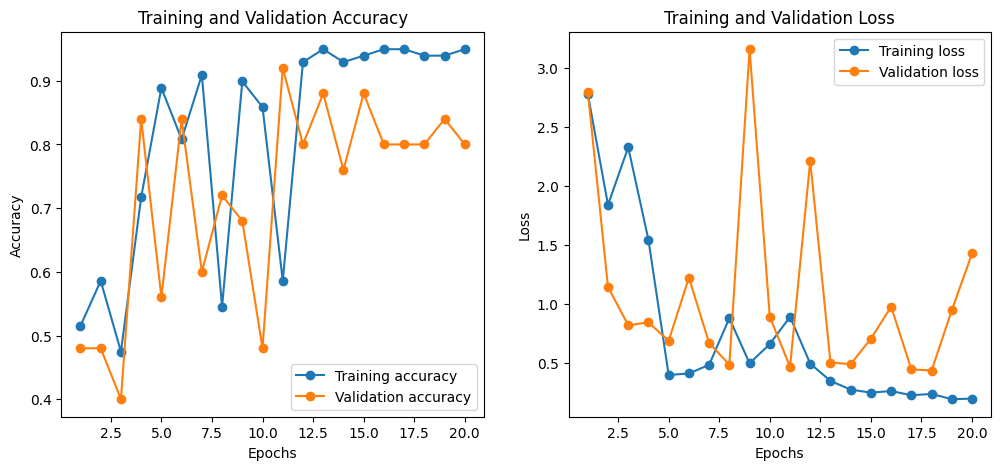

In [14]:
tf.keras.backend.clear_session()
model_1 = make_model(64, 0, "relu")
history_1 = compile_and_train(model_1, X_train, y_train, epochs=20)
plot_training_history(history_1)

Now, that looks more like it. We see improvement and it feels less "random". Is it though?

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.5556 - loss: 3.9767 - val_accuracy: 0.4800 - val_loss: 1.9775
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6566 - loss: 1.1013 - val_accuracy: 0.8800 - val_loss: 0.3906
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8788 - loss: 0.4183 - val_accuracy: 0.8800 - val_loss: 0.4012
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9091 - loss: 0.3200 - val_accuracy: 0.8400 - val_loss: 0.3904
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8687 - loss: 0.3109 - val_accuracy: 0.8400 - val_loss: 0.7638
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9394 - loss: 0.2152 - val_accuracy: 0.8400 - val_loss: 1.0169
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9192 - loss: 0.2436 - val_accuracy: 0.8800 - val_loss: 0.3855
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9394 - loss: 0.2253 - val_accuracy: 0.8000 - val_loss: 1.9746

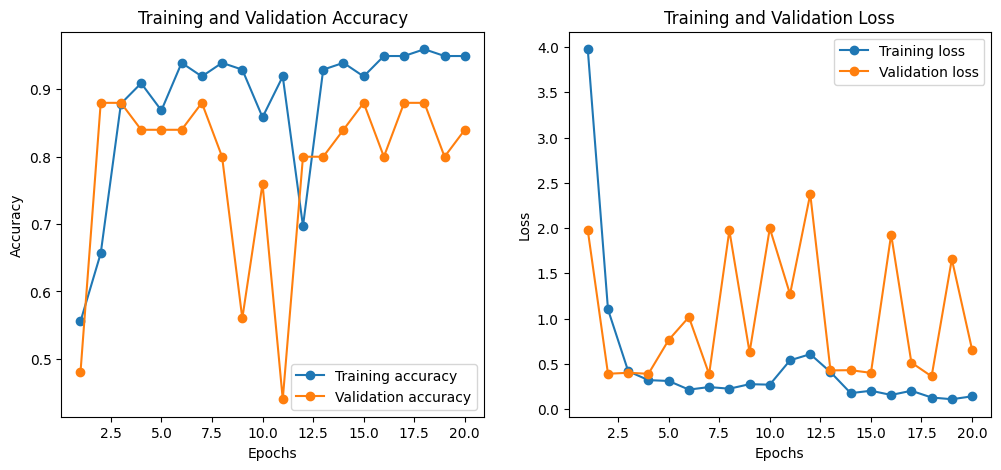

In [15]:
tf.keras.backend.clear_session()
model_1 = make_model(64, 0, "relu")
history_1 = compile_and_train(model_1, X_train, y_train, epochs=20)
plot_training_history(history_1)

I mean... it's better but still not great. Say you want to evaluate different models. If they vary run to run, you could be wrong. But, if we run them 100 times and average results? Now we're getting somewhere

### Model 1 - MORE RUNS

In [16]:
# Run multiple times and average metrics
runs = 100
epochs = 20

acc_hist = []
val_acc_hist = []
loss_hist = []
val_loss_hist = []
final_acc = []
final_val_acc = []
final_loss = []
final_val_loss = []

for i in range(runs):
    tf.keras.backend.clear_session()
    model = make_model(64, 0, "relu")
    history = compile_and_train(model, X_train, y_train, epochs=epochs, verbose=0)
    acc_hist.append(history.history["accuracy"])
    val_acc_hist.append(history.history["val_accuracy"])
    loss_hist.append(history.history["loss"])
    val_loss_hist.append(history.history["val_loss"])
    final_acc.append(history.history["accuracy"][-1])
    final_val_acc.append(history.history["val_accuracy"][-1])
    final_loss.append(history.history["loss"][-1])
    final_val_loss.append(history.history["val_loss"][-1])

# Convert to arrays for averaging
acc_hist = np.array(acc_hist)
val_acc_hist = np.array(val_acc_hist)
loss_hist = np.array(loss_hist)
val_loss_hist = np.array(val_loss_hist)

print("=== Final epoch stats (mean ± std) ===")
print(f"Train acc   : {np.mean(final_acc):.4f} ± {np.std(final_acc):.4f}")
print(f"Val acc     : {np.mean(final_val_acc):.4f} ± {np.std(final_val_acc):.4f}")
print(f"Train loss  : {np.mean(final_loss):.4f} ± {np.std(final_loss):.4f}")
print(f"Val loss    : {np.mean(final_val_loss):.4f} ± {np.std(final_val_loss):.4f}")


=== Final epoch stats (mean ± std) ===
Train acc   : 0.8939 ± 0.1123
Val acc     : 0.7924 ± 0.1151
Train loss  : 0.3489 ± 0.7065
Val loss    : 0.8320 ± 0.6032


Oh god 10 minutes? Realy??? It is too long. Just step it down to 20 next...

### Model 2 - two smaller layers

In [17]:
# Run multiple times and average metrics
runs = 20
epochs = 20

acc_hist = []
val_acc_hist = []
loss_hist = []
val_loss_hist = []
final_acc = []
final_val_acc = []
final_loss = []
final_val_loss = []

for i in range(runs):
    tf.keras.backend.clear_session()
    model = make_model(32, 32, "relu")
    history = compile_and_train(model, X_train, y_train, epochs=epochs, verbose=0)
    acc_hist.append(history.history["accuracy"])
    val_acc_hist.append(history.history["val_accuracy"])
    loss_hist.append(history.history["loss"])
    val_loss_hist.append(history.history["val_loss"])
    final_acc.append(history.history["accuracy"][-1])
    final_val_acc.append(history.history["val_accuracy"][-1])
    final_loss.append(history.history["loss"][-1])
    final_val_loss.append(history.history["val_loss"][-1])

# Convert to arrays for averaging
acc_hist = np.array(acc_hist)
val_acc_hist = np.array(val_acc_hist)
loss_hist = np.array(loss_hist)
val_loss_hist = np.array(val_loss_hist)

print("=== Final epoch stats (mean ± std) ===")
print(f"Train acc   : {np.mean(final_acc):.4f} ± {np.std(final_acc):.4f}")
print(f"Val acc     : {np.mean(final_val_acc):.4f} ± {np.std(final_val_acc):.4f}")
print(f"Train loss  : {np.mean(final_loss):.4f} ± {np.std(final_loss):.4f}")
print(f"Val loss    : {np.mean(final_val_loss):.4f} ± {np.std(final_val_loss):.4f}")


=== Final epoch stats (mean ± std) ===
Train acc   : 0.9157 ± 0.1041
Val acc     : 0.8140 ± 0.1126
Train loss  : 0.2993 ± 0.3706
Val loss    : 0.7033 ± 0.3422


### Model 3 - two "regular size" layers

In [18]:
# Run multiple times and average metrics
runs = 20
epochs = 20

acc_hist = []
val_acc_hist = []
loss_hist = []
val_loss_hist = []
final_acc = []
final_val_acc = []
final_loss = []
final_val_loss = []

for i in range(runs):
    tf.keras.backend.clear_session()
    model = make_model(64, 64, "relu")
    history = compile_and_train(model, X_train, y_train, epochs=epochs, verbose=0)
    acc_hist.append(history.history["accuracy"])
    val_acc_hist.append(history.history["val_accuracy"])
    loss_hist.append(history.history["loss"])
    val_loss_hist.append(history.history["val_loss"])
    final_acc.append(history.history["accuracy"][-1])
    final_val_acc.append(history.history["val_accuracy"][-1])
    final_loss.append(history.history["loss"][-1])
    final_val_loss.append(history.history["val_loss"][-1])

# Convert to arrays for averaging
acc_hist = np.array(acc_hist)
val_acc_hist = np.array(val_acc_hist)
loss_hist = np.array(loss_hist)
val_loss_hist = np.array(val_loss_hist)

print("=== Final epoch stats (mean ± std) ===")
print(f"Train acc   : {np.mean(final_acc):.4f} ± {np.std(final_acc):.4f}")
print(f"Val acc     : {np.mean(final_val_acc):.4f} ± {np.std(final_val_acc):.4f}")
print(f"Train loss  : {np.mean(final_loss):.4f} ± {np.std(final_loss):.4f}")
print(f"Val loss    : {np.mean(final_val_loss):.4f} ± {np.std(final_val_loss):.4f}")


=== Final epoch stats (mean ± std) ===
Train acc   : 0.8995 ± 0.0938
Val acc     : 0.8280 ± 0.0781
Train loss  : 0.3645 ± 0.5023
Val loss    : 0.7795 ± 0.6751


### Model 4 - two layers, activation function tanh

In [19]:
# Run multiple times and average metrics
runs = 20
epochs = 20

acc_hist = []
val_acc_hist = []
loss_hist = []
val_loss_hist = []
final_acc = []
final_val_acc = []
final_loss = []
final_val_loss = []

for i in range(runs):
    tf.keras.backend.clear_session()
    model = make_model(32, 32, "tanh")
    history = compile_and_train(model, X_train, y_train, epochs=epochs, verbose=0)
    acc_hist.append(history.history["accuracy"])
    val_acc_hist.append(history.history["val_accuracy"])
    loss_hist.append(history.history["loss"])
    val_loss_hist.append(history.history["val_loss"])
    final_acc.append(history.history["accuracy"][-1])
    final_val_acc.append(history.history["val_accuracy"][-1])
    final_loss.append(history.history["loss"][-1])
    final_val_loss.append(history.history["val_loss"][-1])

# Convert to arrays for averaging
acc_hist = np.array(acc_hist)
val_acc_hist = np.array(val_acc_hist)
loss_hist = np.array(loss_hist)
val_loss_hist = np.array(val_loss_hist)

print("=== Final epoch stats (mean ± std) ===")
print(f"Train acc   : {np.mean(final_acc):.4f} ± {np.std(final_acc):.4f}")
print(f"Val acc     : {np.mean(final_val_acc):.4f} ± {np.std(final_val_acc):.4f}")
print(f"Train loss  : {np.mean(final_loss):.4f} ± {np.std(final_loss):.4f}")
print(f"Val loss    : {np.mean(final_val_loss):.4f} ± {np.std(final_val_loss):.4f}")


=== Final epoch stats (mean ± std) ===
Train acc   : 0.7035 ± 0.1915
Val acc     : 0.6440 ± 0.1491
Train loss  : 0.5681 ± 0.1539
Val loss    : 0.6160 ± 0.1021


### Model 5 - model 2 but more epochs

In [20]:
# Run multiple times and average metrics
runs = 20
epochs = 50

acc_hist = []
val_acc_hist = []
loss_hist = []
val_loss_hist = []
final_acc = []
final_val_acc = []
final_loss = []
final_val_loss = []

for i in range(runs):
    tf.keras.backend.clear_session()
    model = make_model(32, 32, "relu")
    history = compile_and_train(model, X_train, y_train, epochs=epochs, verbose=0)
    acc_hist.append(history.history["accuracy"])
    val_acc_hist.append(history.history["val_accuracy"])
    loss_hist.append(history.history["loss"])
    val_loss_hist.append(history.history["val_loss"])
    final_acc.append(history.history["accuracy"][-1])
    final_val_acc.append(history.history["val_accuracy"][-1])
    final_loss.append(history.history["loss"][-1])
    final_val_loss.append(history.history["val_loss"][-1])

# Convert to arrays for averaging
acc_hist = np.array(acc_hist)
val_acc_hist = np.array(val_acc_hist)
loss_hist = np.array(loss_hist)
val_loss_hist = np.array(val_loss_hist)

print("=== Final epoch stats (mean ± std) ===")
print(f"Train acc   : {np.mean(final_acc):.4f} ± {np.std(final_acc):.4f}")
print(f"Val acc     : {np.mean(final_val_acc):.4f} ± {np.std(final_val_acc):.4f}")
print(f"Train loss  : {np.mean(final_loss):.4f} ± {np.std(final_loss):.4f}")
print(f"Val loss    : {np.mean(final_val_loss):.4f} ± {np.std(final_val_loss):.4f}")


=== Final epoch stats (mean ± std) ===
Train acc   : 0.9530 ± 0.0497
Val acc     : 0.8320 ± 0.0325
Train loss  : 0.1673 ± 0.1680
Val loss    : 0.6953 ± 0.2275


### Summary

Evaluating models based solely on statistical data, while accurate, is not my thing. Most of these models had very similar accuracies, with standard deviations so high saying one or the other is better cannot be definitive. Lets see how our theoretically best model handles Kraków.

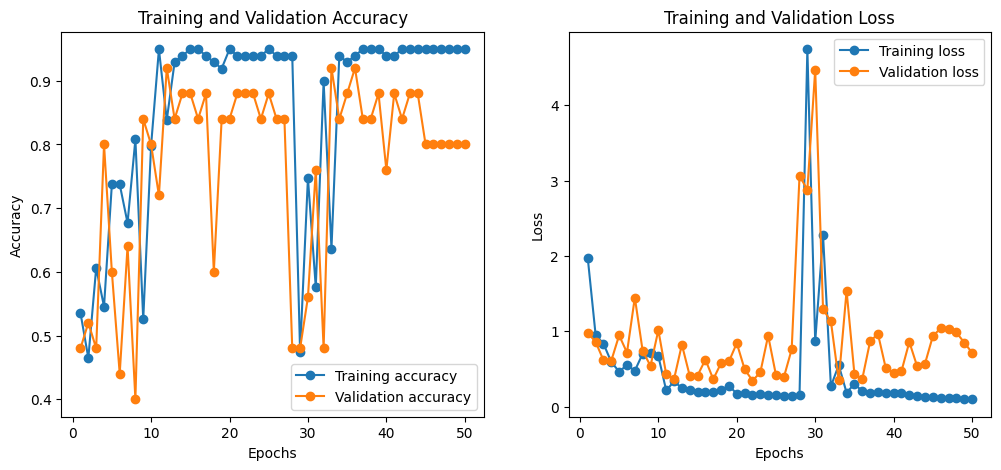

In [33]:
tf.keras.backend.clear_session()

model = make_model(32, 16, "relu")
history = compile_and_train(model, X_train, y_train, epochs=50, verbose=0)
plot_training_history(history)

We can see it getting a little trapped, with accuracy on training data reaching close to 100% while the validation data accuracy is actually dropping. This is overfitting/overtraining at its finest but I don't want to figure out early stopping for it today.

C:\Users\kacpe\AppData\Local\Temp\ipykernel_14508\1508808756.py:46: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  pred_map = np.divide(pred_map, count_map, where=count_map > 0)


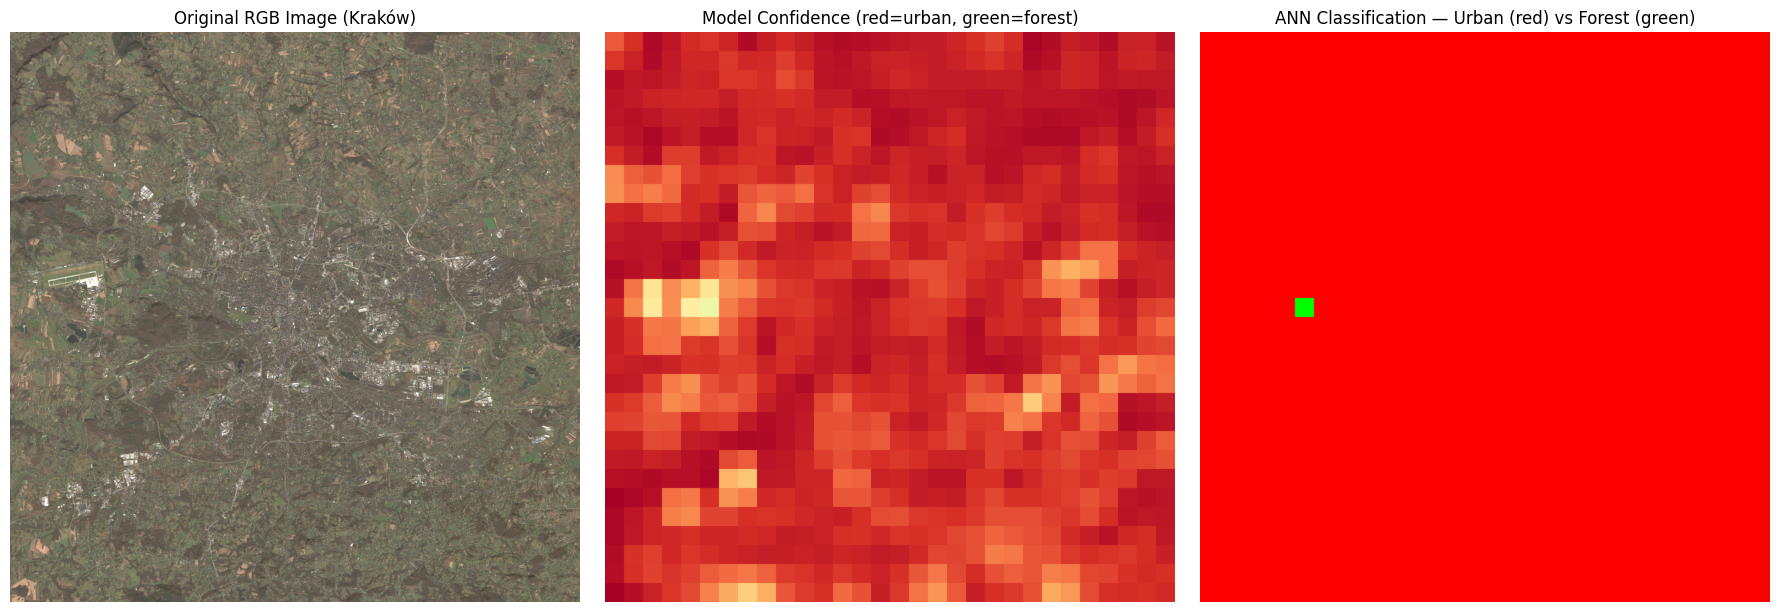

In [34]:
folder_u = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2C_MSIL2A_20251119T094321_N0511_R036_T34UDA_20251119T113511.SAFE\\GRANULE\\L2A_T34UDA_A006298_20251119T094316\\IMG_DATA\\R10m"
band_paths_u = {b: glob.glob(f"{folder_u}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
# Prepare test region - Kraków area
lon_u, lat_u = 19.95, 50.06  # Kraków center
x_u, y_u = transformer_u.transform(lon_u, lat_u)
dx2 = 15000   
dy2 = 15000   
xmin_u, ymin_u, xmax_u, ymax_u = x_u - dx2, y_u - dy2, x_u + dx2, y_u + dy2
scale = 1.0 / 10000.0
b4_crop_u = read_crop(band_paths_u["B04"], (xmin_u, ymin_u, xmax_u, ymax_u)).astype(np.float32) * scale
b3_crop_u = read_crop(band_paths_u["B03"], (xmin_u, ymin_u, xmax_u, ymax_u)).astype(np.float32) * scale
b2_crop_u = read_crop(band_paths_u["B02"], (xmin_u, ymin_u, xmax_u, ymax_u)).astype(np.float32) * scale
cropped_rgb_u = np.dstack((b4_crop_u, b3_crop_u, b2_crop_u)).astype(np.float32)
cropped_rgb_u = np.clip(cropped_rgb_u, 0, 1)

# Classify using model_5 (sliding window approach)
patch_size = 200
stride = 100  # overlap patches for smoother result
H, W = cropped_rgb_u.shape[:2]
# Create prediction map
pred_map = np.zeros((H, W), dtype=np.float32)
count_map = np.zeros((H, W), dtype=np.int32)

patches = []
positions = []

# Extract patches with stride
for y in range(0, H - patch_size + 1, stride):
    for x in range(0, W - patch_size + 1, stride):
        patch = cropped_rgb_u[y:y+patch_size, x:x+patch_size]
        if patch.shape == (patch_size, patch_size, 3):
            patches.append(patch)
            positions.append((y, x))

# Classify all patches at once
if patches:
    patches_array = np.array(patches)
    predictions = model.predict(patches_array, verbose=0).flatten()
    
    # Accumulate predictions
    for (y, x), pred in zip(positions, predictions):
        pred_map[y:y+patch_size, x:x+patch_size] += pred
        count_map[y:y+patch_size, x:x+patch_size] += 1
    
    # Average overlapping predictions
    pred_map = np.divide(pred_map, count_map, where=count_map > 0)
    
    # Threshold to binary (0 = forest, 1 = urban)
    pred_binary = (pred_map > 0.5).astype(int)
else:
    pred_binary = np.zeros((H, W), dtype=int)

# Create RGB visualization
classified_rgb = np.zeros((H, W, 3), dtype=np.uint8)
classified_rgb[pred_binary == 1] = [255, 0, 0]   # red = urban
classified_rgb[pred_binary == 0] = [0, 255, 0]   # green = forest

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(np.clip(cropped_rgb_u * 3, 0, 1))  # brighten for visibility
axes[0].set_title("Original RGB Image (Kraków)")
axes[0].axis("off")

axes[1].imshow(pred_map, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[1].set_title("Model Confidence (red=urban, green=forest)")
axes[1].axis("off")

axes[2].imshow(classified_rgb)
axes[2].set_title("ANN Classification — Urban (red) vs Forest (green)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

Ah, we can see exactly how this overfitting affects our results. While in some forest/natural areas the confidence isnt 100%, it still consistently leans towards it being urban.

Lets try again on less epochs

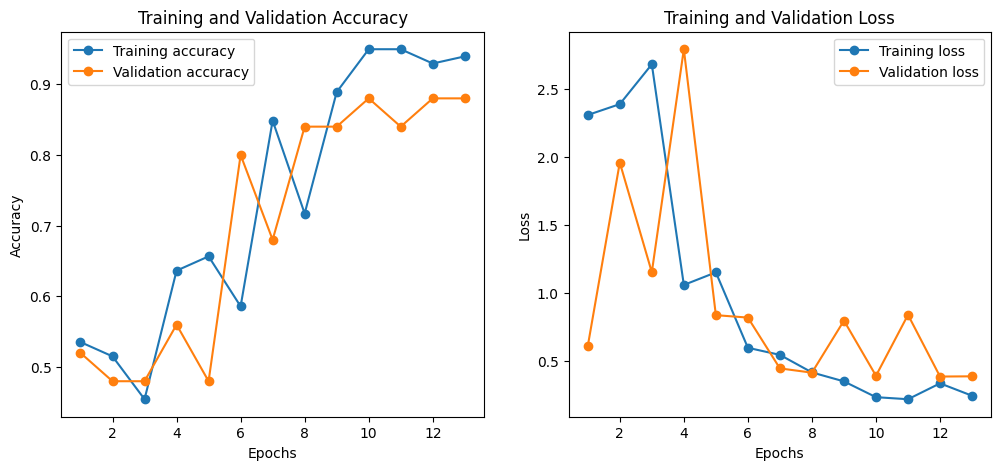

In [35]:
tf.keras.backend.clear_session()
model = make_model(32, 32, "relu")
history = compile_and_train(model, X_train, y_train, epochs=13, verbose=0)
plot_training_history(history)

C:\Users\kacpe\AppData\Local\Temp\ipykernel_14508\1668622335.py:47: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  pred_map = np.divide(pred_map, count_map, where=count_map > 0)


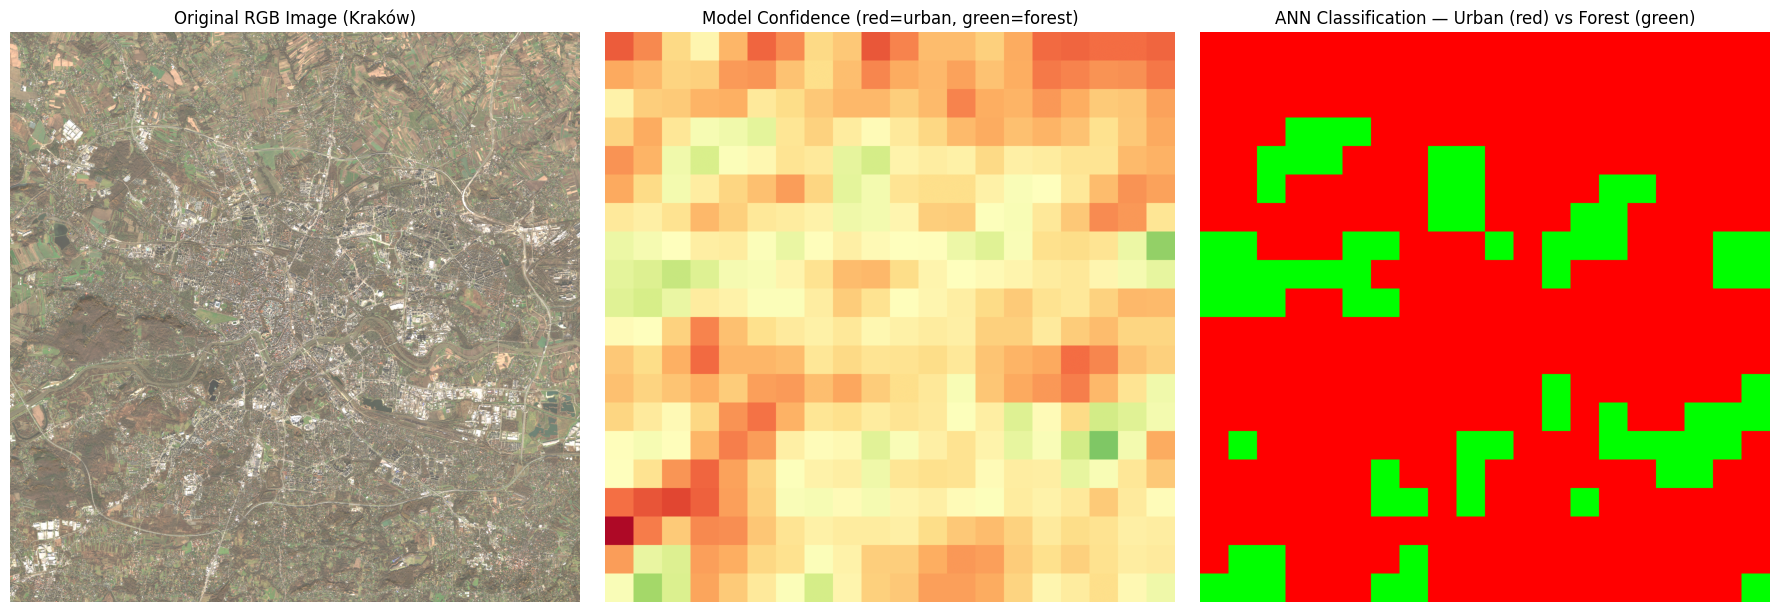

In [36]:
folder_u = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2C_MSIL2A_20251119T094321_N0511_R036_T34UDA_20251119T113511.SAFE\\GRANULE\\L2A_T34UDA_A006298_20251119T094316\\IMG_DATA\\R10m"
band_paths_u = {b: glob.glob(f"{folder_u}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
# Prepare test region - Kraków area
lon_u, lat_u = 19.95, 50.06  # Kraków center
x_u, y_u = transformer_u.transform(lon_u, lat_u)
dx2 = 10000   
dy2 = 10000   
xmin_u, ymin_u, xmax_u, ymax_u = x_u - dx2, y_u - dy2, x_u + dx2, y_u + dy2
scale = 1.0 / 7500.0
b4_crop_u = read_crop(band_paths_u["B04"], (xmin_u, ymin_u, xmax_u, ymax_u)).astype(np.float32) * scale
b3_crop_u = read_crop(band_paths_u["B03"], (xmin_u, ymin_u, xmax_u, ymax_u)).astype(np.float32) * scale
b2_crop_u = read_crop(band_paths_u["B02"], (xmin_u, ymin_u, xmax_u, ymax_u)).astype(np.float32) * scale
cropped_rgb_u = np.dstack((b4_crop_u, b3_crop_u, b2_crop_u)).astype(np.float32)
cropped_rgb_u = np.clip(cropped_rgb_u, 0, 1)

# Classify using model_5 (sliding window approach)
patch_size = 200
stride = 100  # overlap patches for smoother result
H, W = cropped_rgb_u.shape[:2]

# Create prediction map
pred_map = np.zeros((H, W), dtype=np.float32)
count_map = np.zeros((H, W), dtype=np.int32)

patches = []
positions = []

# Extract patches with stride
for y in range(0, H - patch_size + 1, stride):
    for x in range(0, W - patch_size + 1, stride):
        patch = cropped_rgb_u[y:y+patch_size, x:x+patch_size]
        if patch.shape == (patch_size, patch_size, 3):
            patches.append(patch)
            positions.append((y, x))

# Classify all patches at once
if patches:
    patches_array = np.array(patches)
    predictions = model.predict(patches_array, verbose=0).flatten()
    
    # Accumulate predictions
    for (y, x), pred in zip(positions, predictions):
        pred_map[y:y+patch_size, x:x+patch_size] += pred
        count_map[y:y+patch_size, x:x+patch_size] += 1
    
    # Average overlapping predictions
    pred_map = np.divide(pred_map, count_map, where=count_map > 0)
    
    # Threshold to binary (0 = forest, 1 = urban)
    pred_binary = (pred_map > 0.5).astype(int)
else:
    pred_binary = np.zeros((H, W), dtype=int)

# Create RGB visualization
classified_rgb = np.zeros((H, W, 3), dtype=np.uint8)
classified_rgb[pred_binary == 1] = [255, 0, 0]   # red = urban
classified_rgb[pred_binary == 0] = [0, 255, 0]   # green = forest

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(np.clip(cropped_rgb_u * 3, 0, 1))  # brighten for visibility
axes[0].set_title("Original RGB Image (Kraków)")
axes[0].axis("off")

axes[1].imshow(pred_map, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[1].set_title("Model Confidence (red=urban, green=forest)")
axes[1].axis("off")

axes[2].imshow(classified_rgb)
axes[2].set_title("ANN Classification — Urban (red) vs Forest (green)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

Well thats a different result. Is it accurate? Nope. But it is going somewhere

C:\Users\kacpe\AppData\Local\Temp\ipykernel_14508\31442310.py:48: UserWarning: 'where' used without 'out', expect unitialized memory in output. If this is intentional, use out=None.
  pred_map = np.divide(pred_map, count_map, where=count_map > 0)


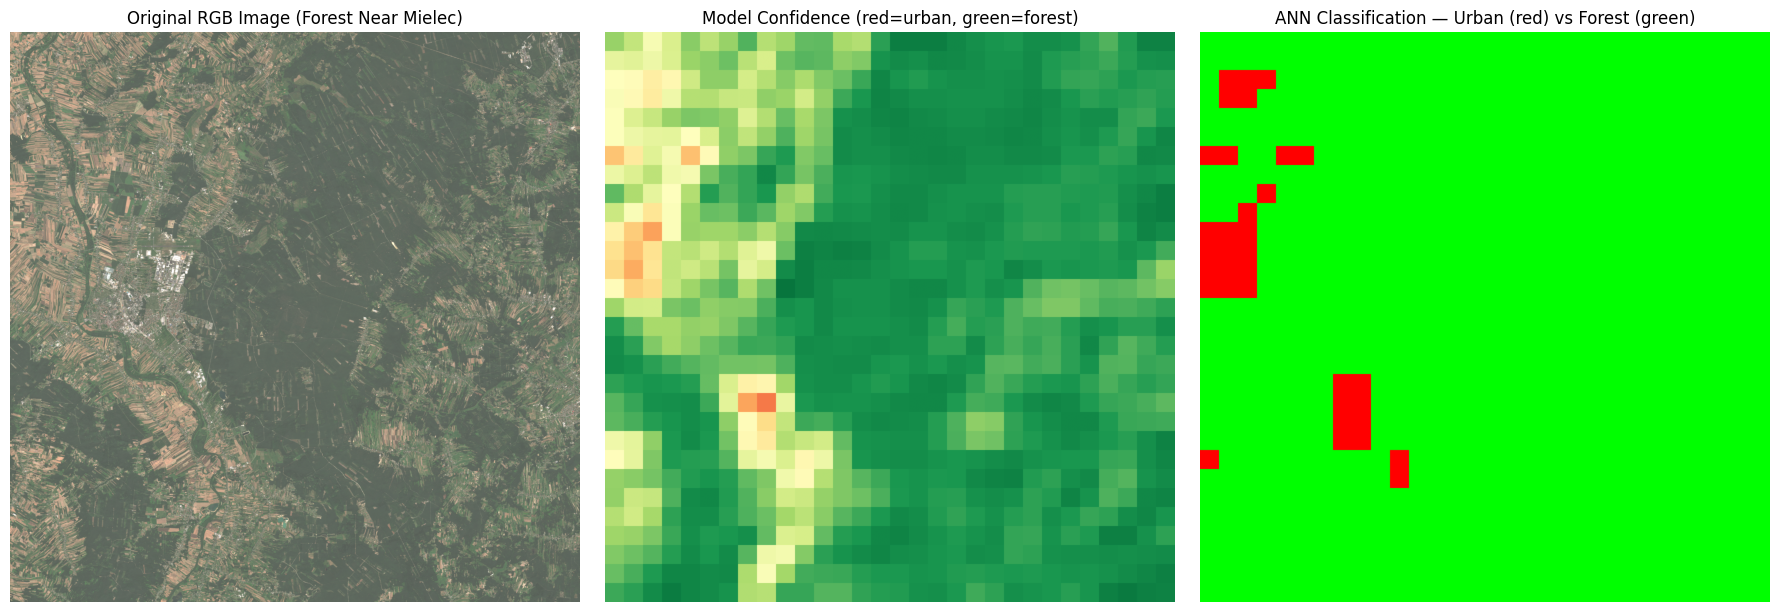

In [37]:
folder_l = "C:\\Users\\kacpe\\Desktop\\Studia\\ML\\S2A_MSIL2A_20250813T094041_N0511_R036_T34UEA_20250813T112012.SAFE\\GRANULE\\L2A_T34UEA_A052972_20250813T094043\\IMG_DATA\\R10m"
band_paths_l = {b: glob.glob(f"{folder_l}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
# Prepare test region - Forest Near Mielec
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
lon_l, lat_l = 21.55724, 50.28835  
x_l, y_l = transformer.transform(lon_l, lat_l)
dx2 = 15000   
dy2 = 15000   
xmin_l, ymin_l, xmax_l, ymax_l = x_l - dx2, y_l - dy2, x_l + dx2, y_l + dy2
scale = 1.0 / 10000.0
b4_crop_l = read_crop(band_paths_l["B04"], (xmin_l, ymin_l, xmax_l, ymax_l)).astype(np.float32) * scale
b3_crop_l = read_crop(band_paths_l["B03"], (xmin_l, ymin_l, xmax_l, ymax_l)).astype(np.float32) * scale
b2_crop_l = read_crop(band_paths_l["B02"], (xmin_l, ymin_l, xmax_l, ymax_l)).astype(np.float32) * scale
cropped_rgb_l = np.dstack((b4_crop_l, b3_crop_l, b2_crop_l)).astype(np.float32)
cropped_rgb_l = np.clip(cropped_rgb_l, 0, 1)

# Classify using model_5 (sliding window approach)
patch_size = 200
stride = 100  # overlap patches for smoother result
H, W = cropped_rgb_l.shape[:2]

# Create prediction map
pred_map = np.zeros((H, W), dtype=np.float32)
count_map = np.zeros((H, W), dtype=np.int32)

patches = []
positions = []

# Extract patches with stride
for y in range(0, H - patch_size + 1, stride):
    for x in range(0, W - patch_size + 1, stride):
        patch = cropped_rgb_l[y:y+patch_size, x:x+patch_size]
        if patch.shape == (patch_size, patch_size, 3):
            patches.append(patch)
            positions.append((y, x))

# Classify all patches at once
if patches:
    patches_array = np.array(patches)
    predictions = model.predict(patches_array, verbose=0).flatten()
    
    # Accumulate predictions
    for (y, x), pred in zip(positions, predictions):
        pred_map[y:y+patch_size, x:x+patch_size] += pred
        count_map[y:y+patch_size, x:x+patch_size] += 1
    
    # Average overlapping predictions
    pred_map = np.divide(pred_map, count_map, where=count_map > 0)
    
    # Threshold to binary (0 = forest, 1 = urban)
    pred_binary = (pred_map > 0.5).astype(int)
else:
    pred_binary = np.zeros((H, W), dtype=int)

# Create RGB visualization
classified_rgb = np.zeros((H, W, 3), dtype=np.uint8)
classified_rgb[pred_binary == 1] = [255, 0, 0]   # red = urban
classified_rgb[pred_binary == 0] = [0, 255, 0]   # green = forest

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(np.clip(cropped_rgb_l * 3, 0, 1))  # brighten for visibility
axes[0].set_title("Original RGB Image (Forest Near Mielec)")
axes[0].axis("off")

axes[1].imshow(pred_map, cmap='RdYlGn_r', vmin=0, vmax=1)
axes[1].set_title("Model Confidence (red=urban, green=forest)")
axes[1].axis("off")

axes[2].imshow(classified_rgb)
axes[2].set_title("ANN Classification — Urban (red) vs Forest (green)")
axes[2].axis("off")

plt.tight_layout()
plt.show()

It handeled Mielec better I guess but still far from acuarate results.